#### Shell commands to install pytorch and torchvision

##### GPU version
```shell
conda install pytorch torchvision pytorch-cuda=11.8 matplotlib ipykernel -c pytorch -c nvidia
```

##### CPU version
```shell
conda install pytorch torchvision cpuonly matplotlib ipykernel -c pytorch
```

In [1]:
import torch
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold


print("PyTorch version:[%s]." % (torch.__version__))
print("torchvision version:[%s]." % (torchvision.__version__))
print("GPU 사용 가능 여부: {}".format(torch.cuda.is_available()))
#print("GPU 이름: {}".format(torch.cuda.get_device_name()))
print("GPU 개수: {}".format(torch.cuda.device_count()))
print("CUDA 버전: {}".format(torch.version.cuda))


USE_CUDA = torch.cuda.is_available() # GPU를 사용가능하면 True, 아니라면 False를 리턴
device = torch.device("cuda" if USE_CUDA else "cpu") # GPU 사용 가능하면 사용하고 아니면 CPU 사용
print("다음 기기로 학습합니다:", device)

PyTorch version:[2.3.0+cu121].
torchvision version:[0.18.0+cu121].
GPU 사용 가능 여부: False
GPU 개수: 0
CUDA 버전: 12.1
다음 기기로 학습합니다: cpu


In [2]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from PIL import Image
import numpy as np
dataset=[]
#train_dataset=[]
#test_dataset=[]
for n in range(1,141):
  try:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/o_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/o_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  image =torch.FloatTensor([image])
  data=image,torch.FloatTensor([[0,1]])
  dataset.append(data)
  try:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/x_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/x_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  image=torch.FloatTensor([image])
  data=image,torch.FloatTensor([[1,0]])
  dataset.append(data)
train_dataset=dataset[:240]
test_dataset=dataset[240:280]

print(len(train_dataset))
print(len(test_dataset))

<ipython-input-4-2e3795afb0d4>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  image =torch.FloatTensor([image])


240
40


X: tensor([[[255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         ...,
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.],
         [255., 255., 255.,  ..., 255., 255., 255.]]])
Y: tensor([[0., 1.]])


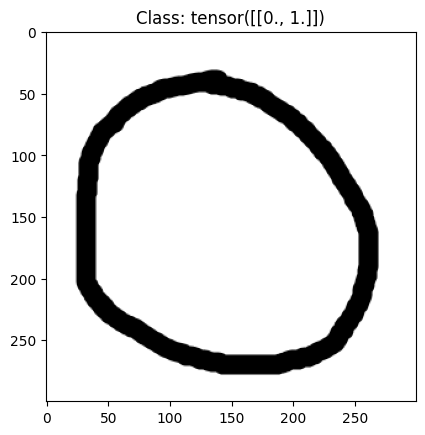

In [ ]:
# Print sample data
cnt=0
for X, Y in test_dataset:
    print('X:', X)
    print('Y:', Y)
    X=[t.numpy() for t in X]
    plt.imshow(X[0], cmap='gray')
    plt.title('Class: ' + str(Y))
    plt.show()
    break

In [4]:
# hyperparameters
training_epochs = 100

learning_rate = 0.001 #adam일시 0.001

input_size = 90000    # 28x28 image       # 고정된 값 (이미지 크기)
hidden_size = 300   # 임의의 값           # 임의의 값 (hidden layer의 노드 개수)
output_size = 2    # 0~9               # 고정된 값 (분류할 클래스 개수)


In [5]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        # 여기에 MLP 모델을 정의해주세요
        self.sequential = nn.Sequential(

            nn.Flatten(),   # 28x28 image를 784x1 vector로 변환

            # 1st layer
            nn.Linear(input_size,hidden_size),
            nn.Sigmoid(),
            # 2nd layer
            nn.Linear(hidden_size,hidden_size),
            nn.Sigmoid(),

            nn.Linear(hidden_size,hidden_size),
            nn.Sigmoid(),

            # 3rd layer
            nn.Linear(hidden_size,output_size)
        )

    def forward(self, x):
        x= x/255
        x = self.sequential(x)

        return x  # 마지막 layer의 output을 리턴

In [6]:
# 작성한 모델 정의
model1 = MLP().to(device) #Sgd
model2 = MLP().to(device) #Adam
print(model1)
print(model2)

MLP(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=90000, out_features=300, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=300, out_features=300, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=300, out_features=2, bias=True)
  )
)
MLP(
  (sequential): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=90000, out_features=300, bias=True)
    (2): Sigmoid()
    (3): Linear(in_features=300, out_features=300, bias=True)
    (4): Sigmoid()
    (5): Linear(in_features=300, out_features=300, bias=True)
    (6): Sigmoid()
    (7): Linear(in_features=300, out_features=2, bias=True)
  )
)


In [7]:
# 비용 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음.
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [ ]:

sgd=[]
for epoch in range(training_epochs):
    avg_loss = 0

    for X, Y in train_dataset:

      X = X.to(device)

      Y = Y.to(device)
      optimizer1.zero_grad()

      Y_hat = model1(X)            # hypothesis : y_hat (예측값)

      loss = criterion(Y_hat, Y)
      loss.backward()
      optimizer1.step()
      avg_loss+=loss
    avg_loss=avg_loss/len(train_dataset)
    sgd.append(avg_loss.cpu().detach())
    if(epoch %10 ==9):
      print("Epoch:", "%04d" % (epoch + 1), "loss =", "{:.9f}".format(avg_loss))

print("Learning finished")

Epoch: 0010 loss = 0.785160661
Epoch: 0020 loss = 0.736577570
Epoch: 0030 loss = 0.718968630
Epoch: 0040 loss = 0.711027980
Epoch: 0050 loss = 0.706780910
Epoch: 0060 loss = 0.704208434
Epoch: 0070 loss = 0.702504873
Epoch: 0080 loss = 0.701284826
Epoch: 0090 loss = 0.700333893
Epoch: 0100 loss = 0.699498653
Epoch: 0110 loss = 0.698568523
Epoch: 0120 loss = 0.697145879
Epoch: 0130 loss = 0.693761051
Epoch: 0140 loss = 0.683682203
Epoch: 0150 loss = 0.657581568
Epoch: 0160 loss = 0.607853830
Epoch: 0170 loss = 0.540832460
Epoch: 0180 loss = 0.478779078
Epoch: 0190 loss = 0.442116588
Epoch: 0200 loss = 0.461104363
Learning finished


In [ ]:
adam=[]
for epoch in range(training_epochs):
    avg_loss = 0

    for X, Y in train_dataset:

      X = X.to(device)


      Y = Y.to(device)
      optimizer2.zero_grad()

      Y_hat = model2(X)            # hypothesis : y_hat (예측값)

      loss = criterion(Y_hat, Y)
      loss.backward()
      optimizer2.step()
      avg_loss+=loss
    avg_loss=avg_loss/len(train_dataset)
    adam.append(avg_loss.cpu().detach())
    if(epoch %10 ==9):
      print("Epoch:", "%04d" % (epoch + 1), "loss =", "{:.9f}".format(avg_loss))

print("Learning finished")

Epoch: 0010 loss = 0.697270751
Epoch: 0020 loss = 0.697065234
Epoch: 0030 loss = 0.696892917
Epoch: 0040 loss = 0.696614444
Epoch: 0050 loss = 0.696299553
Epoch: 0060 loss = 0.695920527
Epoch: 0070 loss = 0.695351720
Epoch: 0080 loss = 0.694598973
Epoch: 0090 loss = 0.693419516
Epoch: 0100 loss = 0.693215013
Epoch: 0110 loss = 0.693192899
Epoch: 0120 loss = 0.693180919
Epoch: 0130 loss = 0.693176091
Epoch: 0140 loss = 0.693174601
Epoch: 0150 loss = 0.693174481
Epoch: 0160 loss = 0.693175375
Epoch: 0170 loss = 0.693172157
Epoch: 0180 loss = 0.693173945
Epoch: 0190 loss = 0.693173945
Epoch: 0200 loss = 0.693173885
Learning finished


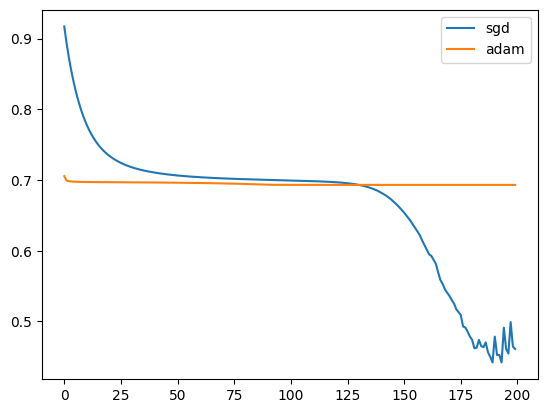

In [ ]:
import matplotlib.pyplot as plt

plt.plot(sgd,label="sgd")
plt.plot(adam,label="adam")
plt.legend()

In [ ]:
with torch.no_grad():  # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    cnt=0
    for X_test,Y_test in test_dataset:

      prediction = model2(X_test.to(device))
      a=[t.numpy() for t in Y_test]
      b=[t.cpu().numpy() for t in prediction]
      #if(b[0][0]<0 and b[0][1]<0 or b[0][0]>0 and b[0][1]>0):
        #print("Wrong Prediction: ", b[0][0],b[0][1])
      #print("Label: ",a[0][0],a[0][1])
      #print("Prediction: ", b[0][0],b[0][1])
      if(a[0][0]==1 and b[0][0]>b[0][1]):
        cnt+=1
      elif(a[0][1]==1 and b[0][1]>b[0][0]):
        cnt+=1
    print("Accurancy: ",cnt/len(test_dataset))

Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 0.0
Prediction:  0.03332534 0.033275954
Label:  0.0 1.0
Prediction:  0.03332534 0.033275954
Label:  1.0 

In [8]:
from PIL import Image
import numpy as np
dataset=[]
#train_dataset=[]
#test_dataset=[]
for n in range(1,141):
  try:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/o_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/o_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  #image =torch.FloatTensor([image])
  #data=image,torch.FloatTensor([[0,1]])
  data=image,0
  dataset.append(data)
  try:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/x_{}.png'.format(n)).convert('L')
  except:
    image = Image.open('/content/drive/MyDrive/ColabNotebooks/Dataset/x_{}.jpg'.format(n)).convert('L')
  image = np.array(image)
  #image=torch.FloatTensor(image])
  #data=image,torch.FloatTensor([[1,0]])
  data=image,1
  dataset.append(data)
train_dataset=dataset[:240]
test_dataset=dataset[240:280]

print(len(train_dataset))
print(len(test_dataset))

240
40


In [ ]:
kfold = KFold(n_splits=7, shuffle=True)
sgd=[]
accurancy=0;
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
  print(f'FOLD {fold}')
  #print((train_ids, test_ids))
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
  trainloader = torch.utils.data.DataLoader(
                      dataset,
                      sampler=train_subsampler)
  testloader = torch.utils.data.DataLoader(
                      dataset, sampler=test_subsampler)

  fold_sgd=[]
  for epoch in range(10):#epoch
    avg_loss = 0

    for X, Y in trainloader:
      X = X.to(device)

      Y = Y.to(device)
      optimizer2.zero_grad()

      Y_hat = model2(X)            # hypothesis : y_hat (예측값)

      loss = criterion(Y_hat, Y)
      loss.backward()
      optimizer2.step()
      avg_loss+=loss
    avg_loss=avg_loss/len(train_dataset)
    fold_sgd.append(avg_loss.cpu().detach())
    print("Epoch:", "%04d" % (epoch + 1), "loss =", "{:.9f}".format(avg_loss))
  sgd.append(fold_sgd)
  with torch.no_grad():  # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    cnt=0
    for X_test,Y_test in testloader:

      prediction = model2(X_test.to(device))
      a=[t.numpy() for t in Y_test]
      b=[t.cpu().numpy() for t in prediction]
      #if(b[0][0]<0 and b[0][1]<0 or b[0][0]>0 and b[0][1]>0):
        #print("Wrong Prediction: ", b[0][0],b[0][1])
      if(a[0]==1 and b[0][0]>b[0][1]):
        cnt+=1
      elif(a[0]==1 and b[0][1]>b[0][0]):
        cnt+=1
    accurancy+=cnt/len(test_dataset)
    print("Accurancy: ",cnt/len(test_dataset))
print("Total Accurancy: ",accurancy/7)
print("Learning finished")


FOLD 0
Epoch: 0001 loss = 0.771668971
Epoch: 0002 loss = 0.731991231
Epoch: 0003 loss = 0.723297834
Epoch: 0004 loss = 0.753403962
Epoch: 0005 loss = 0.704884529
Epoch: 0006 loss = 0.695252538
Epoch: 0007 loss = 0.694069624
Epoch: 0008 loss = 0.693667829
Epoch: 0009 loss = 0.693880022
